In [ ]:
!pip install scikit-image scikit-learn opencv-python numpy joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.ndimage import rotate
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.measure import regionprops, label
from sklearn.svm import SVC
import joblib
from skimage.feature import hog
import xml.etree.ElementTree as ET
from tqdm import tqdm

# ==========================================
# CENTRALIZED PATH CONFIGURATION
# ==========================================
# Define the root directory. Everything else will be relative to this.
PROJECT_ROOT = '/content/drive/MyDrive/LicensePlateRecognition'

# Data Paths
DATA_ROOT = os.path.join(PROJECT_ROOT, 'Data')
RAW_DATA_DIR = os.path.join(DATA_ROOT, 'LetNumTrainData')
SVM_TRAIN_DIR = os.path.join(DATA_ROOT, 'SVM_Training_Data')
TEST_IMAGES_DIR = os.path.join(DATA_ROOT, 'TestImages')

# Model Paths
MODELS_ROOT = os.path.join(PROJECT_ROOT, 'models')
SVC_MODEL_DIR = os.path.join(MODELS_ROOT, 'svc')
SVC_MODEL_PATH = os.path.join(SVC_MODEL_DIR, 'svc_new_dataset_trial.pkl')

# Create necessary directories automatically
for path in [PROJECT_ROOT, DATA_ROOT, RAW_DATA_DIR, SVM_TRAIN_DIR, TEST_IMAGES_DIR, MODELS_ROOT, SVC_MODEL_DIR]:
    os.makedirs(path, exist_ok=True)

print(f"Project configured at: {PROJECT_ROOT}")
print("Directories initialized.")

Project configured at: /content/drive/MyDrive/LicensePlateRecognition
Directories initialized.


In [ ]:
!pip install -q kagglehub

import kagglehub
import shutil
from skimage.feature import local_binary_pattern

print("Downloading dataset from Kaggle...")
cache_path = kagglehub.dataset_download("francescopettini/license-plate-characters-detection-ocr")

print(f"Moving data to: {RAW_DATA_DIR}")

def find_dataset_root(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'A' in dirs and '0' in dirs:
            return root
    return start_path

source_data_root = find_dataset_root(cache_path)

# Check if we already have data to avoid re-copying unnecessarily
if not os.path.exists(os.path.join(RAW_DATA_DIR, 'A')) and not os.path.exists(os.path.join(RAW_DATA_DIR, 'LP-characters')):
    print("Copying files... this may take a moment.")
    for item in os.listdir(source_data_root):
        s = os.path.join(source_data_root, item)
        d = os.path.join(RAW_DATA_DIR, item)
        if os.path.isdir(s):
            if os.path.exists(d):
                shutil.rmtree(d)
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)
    print("Data successfully moved to Drive!")
else:
    print("Data already appears to exist in Drive. Skipping copy.")

100%|██████████| 12.4M/12.4M [00:00<00:00, 14.0MB/s]

Extracting files...


Moving data to: /content/drive/MyDrive/LicensePlateRecognition/Data/LetNumTrainData
Data already appears to exist in Drive. Skipping copy.


In [ ]:
# Use the centralized variables
# Note: Adjust 'LP-characters' if the dataset structure changes
KAGGLE_DATA_DIR = os.path.join(RAW_DATA_DIR, 'LP-characters')
IMAGES_DIR = os.path.join(KAGGLE_DATA_DIR, 'images')
ANNOT_DIR = os.path.join(KAGGLE_DATA_DIR, 'annotations')

# Where to save the cropped characters for SVM training
OUTPUT_DIR = SVM_TRAIN_DIR

def extract_characters():
    # Check if extraction is already done
    # We check a few key folders. If '0' and 'A' exist and are not empty, we assume it's done.
    if os.path.exists(os.path.join(OUTPUT_DIR, '0')) and len(os.listdir(os.path.join(OUTPUT_DIR, '0'))) > 0:
         if os.path.exists(os.path.join(OUTPUT_DIR, 'A')) and len(os.listdir(os.path.join(OUTPUT_DIR, 'A'))) > 0:
             print(f"Data appears to be already extracted in {OUTPUT_DIR}. Skipping extraction.")
             return

    if not os.path.exists(IMAGES_DIR) or not os.path.exists(ANNOT_DIR):
        print(f"Error: Could not find dataset components at {KAGGLE_DATA_DIR}")
        print(f"Check if {IMAGES_DIR} exists.")
        return

    # Create output directories for classes 0-9 and A-Z
    classes = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for char in classes:
        os.makedirs(os.path.join(OUTPUT_DIR, char), exist_ok=True)

    xml_files = [f for f in os.listdir(ANNOT_DIR) if f.endswith('.xml')]
    print(f"Found {len(xml_files)} XML files. Starting extraction...")

    count = 0

    for xml_file in tqdm(xml_files):
        try:
            # 1. Parse XML
            tree = ET.parse(os.path.join(ANNOT_DIR, xml_file))
            root = tree.getroot()

            # 2. Load corresponding image
            # XML filename usually matches image filename (e.g., 0015.xml -> 0015.png)
            filename_base = os.path.splitext(xml_file)[0]
            img_path = os.path.join(IMAGES_DIR, f"{filename_base}.png")

            # Fallback if png doesn't exist, try jpg
            if not os.path.exists(img_path):
                 img_path = os.path.join(IMAGES_DIR, f"{filename_base}.jpg")

            if not os.path.exists(img_path):
                continue

            image = cv2.imread(img_path)
            if image is None: continue

            # 3. Extract each character
            for obj in root.findall('object'):
                label = obj.find('name').text.upper()

                # Only process valid license plate characters
                if label not in classes:
                    continue

                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Crop the character
                # Add a tiny padding if possible to ensure we don't cut edges
                h, w, _ = image.shape
                ymin = max(0, ymin - 1)
                xmin = max(0, xmin - 1)
                ymax = min(h, ymax + 1)
                xmax = min(w, xmax + 1)

                roi = image[ymin:ymax, xmin:xmax]

                # Save to the specific class folder
                save_path = os.path.join(OUTPUT_DIR, label, f"{filename_base}_{count}.jpg")
                cv2.imwrite(save_path, roi)
                count += 1

        except Exception as e:
            # print(f"Skipped {xml_file} due to error: {e}")
            pass

    print(f"Extraction Complete! {count} characters saved to {OUTPUT_DIR}")

# Execute the extraction
extract_characters()

Data appears to be already extracted in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data. Skipping extraction.


In [ ]:
IMG_SIZE = (32, 32)
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (4, 4)
HOG_CELLS_PER_BLOCK = (2, 2)

def resize_with_padding(image, target_size=(32, 32)):
    """
    Resizes an image to target_size while maintaining aspect ratio
    by adding black padding.
    """
    h, w = image.shape
    desired_size = max(h, w)

    # Create a black square canvas
    new_img = np.zeros((desired_size, desired_size), dtype=np.uint8)

    # Calculate centering position
    y_off = (desired_size - h) // 2
    x_off = (desired_size - w) // 2

    # Paste the character in the center
    new_img[y_off:y_off+h, x_off:x_off+w] = image

    # Now resize the square canvas to the target size (e.g., 32x32)
    final_img = cv2.resize(new_img, target_size, interpolation=cv2.INTER_AREA)
    return final_img

def extract_hog_features(image):
    """
    Standardized HOG feature extractor with Padding.
    """
    # 1. Resize with Padding (New Logic)
    img_resized = resize_with_padding(image, IMG_SIZE)

    # 2. Compute HOG
    features = hog(img_resized,
                   orientations=HOG_ORIENTATIONS,
                   pixels_per_cell=HOG_PIXELS_PER_CELL,
                   cells_per_block=HOG_CELLS_PER_BLOCK,
                   block_norm='L2-Hys',
                   transform_sqrt=True,
                   visualize=False)
    return features

In [ ]:
SUPPORTED_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')

def process_image(image_path):
    """Convert image to grayscale and binary"""
    if not image_path.lower().endswith(SUPPORTED_EXTENSIONS):
        return None, None

    car_image = imread(image_path, as_gray=True)
    gray_car_image = car_image * 255
    threshold_value = threshold_otsu(gray_car_image)
    binary_car_image = gray_car_image > threshold_value
    return gray_car_image, binary_car_image

In [ ]:
def cca(image_path):
    """
    Standard Connected Component Analysis (CCA) Approach.
    Finds the plate by looking for rectangular regions in the binary image
    that satisfy specific license plate geometry.
    """
    # 1. Preprocessing
    gray_car_image, binary_car_image = process_image(image_path)
    if gray_car_image is None:
        return [], []

    # 2. Label Connected Components
    #    This separates all white blobs in the image
    label_image = measure.label(binary_car_image)
    regions = regionprops(label_image)

    plate_like_objects = []
    plate_objects_cordinates = []

    # Image dimensions
    img_h, img_w = gray_car_image.shape
    img_area = img_h * img_w

    for region in regions:
        # Get bounding box
        min_row, min_col, max_row, max_col = region.bbox
        region_height = max_row - min_row
        region_width = max_col - min_col

        # Calculate geometric properties
        aspect_ratio = region_width / region_height
        area = region.area

        extent = area / (region_width * region_height)


        if aspect_ratio < 2.0 or aspect_ratio > 6.0:
            continue

        # 2. Height relative to image:

        if region_height < (0.02 * img_h) or region_height > (0.2 * img_h):
            continue

        # 3. Area relative to image:
        #    Too small = noise. Too big = Bumper/Background.
        if area < (0.01 * img_area) or area > (0.15 * img_area):
            continue

        # 4. Extent (Solidity):

        if extent < 0.45:
            continue

        # If we pass all filters, it's a candidate
        roi = gray_car_image[min_row:max_row, min_col:max_col]
        plate_like_objects.append(roi)
        plate_objects_cordinates.append((min_row, min_col, max_row, max_col))

    return plate_like_objects, plate_objects_cordinates

In [ ]:
def detect_blue_strip_plate(image_path):
    """
    Original working version without full-image rotation.
    """
    img = cv2.imread(image_path)
    if img is None: return None

    # 1. Convert to HSV to detect Blue
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 100, 50])
    upper_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Clean up noise
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 2. Find Blue Contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = h / w

        if h > 15 and 1.5 < aspect_ratio < 6.0:
            # 3. Predict Plate Location
            plate_x = x
            plate_y = y
            # Width guess: Strip width + (11 * Strip width)
            plate_w_guess = w + (int(w * 12))
            plate_h = h

            # Add padding
            pad = int(h * 0.1)
            plate_y = max(0, plate_y - pad)
            plate_h = plate_h + (2 * pad)

            # Ensure bounds
            img_h, img_w, _ = img.shape
            if plate_x + plate_w_guess > img_w:
                plate_w_guess = img_w - plate_x
            if plate_y + plate_h > img_h:
                plate_h = img_h - plate_y

            plate_color = img[plate_y:plate_y+plate_h, plate_x:plate_x+plate_w_guess]
            return cv2.cvtColor(plate_color, cv2.COLOR_BGR2GRAY)

    return None

In [ ]:
def select_plate(plate_like_objects):
    """Select the best plate candidate from detected objects"""
    best_candidate = None
    best_score = -1
    best_regions = None
    best_char_dims = None

    print(f"\nAnalyzing {len(plate_like_objects)} plate-like objects:")

    for idx, candidate in enumerate(plate_like_objects):
        h, w = candidate.shape
        aspect_ratio = w / h

        thresh = threshold_otsu(candidate)
        binary_plate = candidate > thresh
        license_plate = np.logical_not(binary_plate)
        labelled_plate = measure.label(license_plate)
        regions = list(regionprops(labelled_plate))
        region_count = len(regions)

        print(f"\n  Object {idx}: h={h}, w={w}, aspect_ratio={aspect_ratio:.2f}, regions={region_count}")

        # Calculate character-like region count
        char_height_min = 0.35 * h
        char_height_max = 0.60 * h
        char_width_min = 0.02 * w
        char_width_max = 0.15 * w

        char_count = 0
        for region in regions:
            y0, x0, y1, x1 = region.bbox
            region_h = y1 - y0
            region_w = x1 - x0
            if char_height_min <= region_h <= char_height_max and char_width_min <= region_w <= char_width_max:
                char_count += 1

        # Scoring heuristics
        score = 0
        if 2.0 <= aspect_ratio <= 5.0:
            score += 10
        if 4 <= region_count <= 10:
            score += 5
        if char_count >= 4:
            score += (char_count * 2)

        print(f"    Score: {score}")

        if score > best_score:
            best_score = score
            best_candidate = candidate
            best_regions = regions
            character_dimensions = (char_height_min, char_height_max, char_width_min, char_width_max)
            best_char_dims = character_dimensions

    if best_candidate is not None and best_score > 0:
        print(f"\n✓ Selected object with score {best_score}")
        return best_candidate, best_regions, best_char_dims

    return "Plate Not Found"

def segmentation(image_path):
    """
    Segments characters from a license plate image.
    It employs a hybrid strategy: first attempting to detect the specific blue strip
    found on Turkish plates, falling back to standard CCA if that fails.

    It enforces a maximum limit of 8 characters (standard for Turkey) by filtering
    outliers based on height consistency.
    """
    gray_plate = None
    character_dimensions = None

    # --- STRATEGY 1: Blue Strip Detection (Specific for Turkey) ---
    print(f"[INFO] Checking for Blue Strip in {image_path}...")
    gray_plate = detect_blue_strip_plate(image_path)

    if gray_plate is not None:
        print("[INFO] Blue strip detected. Using strip-based logic.")
        h, w = gray_plate.shape
        # Estimate character dimensions based on the crop height
        character_dimensions = (0.35 * h, 0.90 * h, 0.02 * w, 0.25 * w)
    else:
        # --- STRATEGY 2: Fallback to CCA (Connected Component Analysis) ---
        print("[INFO] No Blue strip found. Falling back to standard CCA...")
        plate_like_objects, plate_coords = cca(image_path)
        result = select_plate(plate_like_objects)

        if result == "Plate Not Found":
            return [], [], None

        gray_plate, _, character_dimensions = result

    # --- COMMON PIPELINE ---
    # 1. Ensure image is in uint8 format for OpenCV compatibility
    if gray_plate.dtype != np.uint8:
        if gray_plate.max() <= 1.0:
            gray_plate = (gray_plate * 255).astype(np.uint8)
        else:
            gray_plate = gray_plate.astype(np.uint8)

    # 2. Adaptive Thresholding
    # Creates a binary image robust to varying lighting conditions
    binary_plate_uint = cv2.adaptiveThreshold(
        gray_plate, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        13, 5
    )

    # 3. Masking the Blue Strip Region
    # The 'TR' strip on the left often creates noise in the binary image.
    # We mask the first 8% of the width to ensure clean segmentation.
    h, w = binary_plate_uint.shape
    binary_plate_uint[:, 0:int(w * 0.08)] = 0

    # 4. Connected Component Labeling
    binary_plate_bool = binary_plate_uint > 0
    new_label_image = label(binary_plate_bool)
    new_char_regions = regionprops(new_label_image)

    min_height, max_height, min_width, max_width = character_dimensions
    candidate_chars = []

    # 5. Extract Candidates
    for region in new_char_regions:
        y0, x0, y1, x1 = region.bbox
        h_char = y1 - y0
        w_char = x1 - x0

        # Filter by dimensions
        if min_height < h_char < max_height and min_width < w_char < max_width:
            roi = gray_plate[y0:y1, x0:x1]

            # Resize to standard input size for the recognition model
            resized_char_uint = resize_with_padding(roi, target_size=(32, 32))

            # Store metadata (height, x-pos) alongside the image for post-processing
            candidate_chars.append({
                'image': resized_char_uint,
                'x': x0,
                'h': h_char
            })

    # --- CRITICAL STEP: ENFORCE MAXIMUM 8 CHARACTERS ---
    # Turkish plates have a maximum of 8 characters. If we detect more,
    # the extras are likely noise (screws, frame edges, dirt).
    if len(candidate_chars) > 8:
        # Heuristic: Valid characters usually have very similar heights.
        # Noise (like screws) is often significantly smaller or larger.

        # Calculate the median height of all candidates
        heights = [c['h'] for c in candidate_chars]
        median_h = np.median(heights)

        # Sort candidates by their deviation from the median height (ascending)
        # The candidates closest to the median height are preserved.
        candidate_chars.sort(key=lambda item: abs(item['h'] - median_h))

        # Keep only the top 8 most consistent candidates
        candidate_chars = candidate_chars[:8]

    # 6. Final Sorting
    # Sort the validated characters from left to right based on X-coordinate
    candidate_chars.sort(key=lambda item: item['x'])

    # Unpack into return lists
    final_char_images = [c['image'] for c in candidate_chars]
    column_positions = [c['x'] for c in candidate_chars]

    return final_char_images, column_positions, gray_plate

In [ ]:
def predict_license_plate(image_path, model):
    characters, positions, plate_img = segmentation(image_path)

    if not characters:
        print("No characters found")
        return None

    print(f"Found {len(characters)} characters.")

    predictions = []
    confidences = []

    fig, axes = plt.subplots(1, len(characters), figsize=(15, 3))
    if len(characters) == 1:
        axes = [axes]

    for idx, char_img in enumerate(characters):
        features = extract_hog_features(char_img)
        features = features.reshape(1, -1)

        pred = model.predict(features)[0]
        proba = model.predict_proba(features).max() * 100

        predictions.append(pred)
        confidences.append(proba)

        axes[idx].imshow(char_img, cmap='gray')
        axes[idx].set_title(f"{pred}\n{proba:.0f}%")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    raw_plate = "".join(predictions)

    # Step 1: Apply smart correction based on confidence scores
    corrected_plate = smart_correction(predictions, confidences, threshold=40)

    # Step 2: Apply format-based correction
    final_plate = intelligent_turkish_format_v2(corrected_plate)

    print(f"RAW PREDICTION:     {raw_plate}")
    print(f"SMART CORRECTED:    {corrected_plate}")
    print(f"FINAL PREDICTION:   {final_plate}")

    return final_plate

In [ ]:
letters = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
    'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]


def read_training_data(training_directory):
    image_data = []
    target_data = []
    processed_files_count = 0

    if not os.path.exists(training_directory):
        print(f"Error: Training directory not found at {training_directory}")
        return np.array([]), np.array([])

    print(f"Reading data from: {training_directory}")

    for each_letter in letters:
        letter_path = os.path.join(training_directory, each_letter)
        if not os.path.exists(letter_path):
            print(f"  Skipping directory: {letter_path} (does not exist)")
            continue

        files = os.listdir(letter_path)
        found_files_in_folder = 0
        for file_name in files:
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(letter_path, file_name)
                try:
                    # 1. Load Original
                    img_details = imread(image_path, as_gray=True)

                    # Convert to standard uint8 0-255
                    if img_details.max() <= 1.0:
                        img_details = (img_details * 255).astype(np.uint8)
                    else:
                        img_details = img_details.astype(np.uint8)

                    # --- DATA AUGMENTATION ---
                    angles = [0, -10, -5, 5, 10]  # More rotation variants

                    for angle in angles:
                        if angle == 0:
                            img_rot = img_details
                        else:
                            # Rotate using constant black background (cval=0)
                            img_rot = rotate(img_details, angle, reshape=False, mode='constant', cval=0)

                        # Extract Features (uses your resize_with_padding automatically)
                        fd = extract_hog_features(img_rot)

                        image_data.append(fd)
                        target_data.append(each_letter)
                        processed_files_count += 1
                        found_files_in_folder += 1

                except Exception as e:
                    print(f"    Error processing {image_path}: {e}")
                    pass # Continue to next file even if one fails
        if found_files_in_folder > 0:
            print(f"  Found {found_files_in_folder} image(s) in {letter_path}")

    print(f"Finished reading data. Total processed files: {processed_files_count}")
    return np.array(image_data), np.array(target_data)

In [ ]:
# Confusion Dictionary (Common OCR errors)
confusions_to_digit = {'Z': '2', 'S': '5', 'B': '8', 'A': '4', 'G': '6', 'O': '0','D': '0', 'J': '7'}
confusions_to_letter = {'2': 'Z', '5': 'S', '8': 'B', '4': 'A', '6': 'G', '0': 'O', '7': 'J'}

def smart_correction(predictions, confidences, threshold=40):
    """
    Apply corrections when confidence is below threshold for confusing pairs.
    Uses position-based rules for Turkish plates where we KNOW certain positions
    must be digits or letters.
    """
    result = list(predictions)

    # Turkish plate format: DD LLL DDD (2 digits, 1-3 letters, 2-4 digits)
    # Positions 0,1 should be digits
    # Last 2-4 positions should be digits

    # Fix first 2 positions (must be digits)
    for i in range(min(2, len(result))):
        if confidences[i] < threshold and result[i] in confusions_to_digit:
            print(f"[SMART FIX] Position {i}: '{result[i]}' -> '{confusions_to_digit[result[i]]}' (conf: {confidences[i]:.0f}%)")
            result[i] = confusions_to_digit[result[i]]

    # Fix last 3 positions (usually digits)
    for i in range(max(0, len(result)-3), len(result)):
        if confidences[i] < threshold and result[i] in confusions_to_digit:
            print(f"[SMART FIX] Position {i}: '{result[i]}' -> '{confusions_to_digit[result[i]]}' (conf: {confidences[i]:.0f}%)")
            result[i] = confusions_to_digit[result[i]]

    return "".join(result)

def intelligent_turkish_format_v2(plate_str):
    """
    Fits the plate_str into standard Turkish formats (e.g., 99 AAA 999).
    Uses comprehensive homoglyph mapping to fix errors like '25K' -> '254' or '25X'.
    """
    # 1. CLEAN INPUT: Remove spaces/special chars to get raw sequence
    raw_plate = "".join(c for c in plate_str if c.isalnum()).upper()
    current_len = len(raw_plate)

    # 2. ROBUST MAPPINGS (The "Repair Kit")
    # Letters that look like Digits (used when we expect a Digit)
    to_digit = {
        'O': '0', 'D': '0', 'Q': '0', 'U': '0', 'C': '0',
        'I': '1', 'L': '1', '|': '1', 'J': '1',
        'Z': '2',
        'B': '8', '&': '8',
        'A': '4',
        'S': '5',
        'G': '6',
        'T': '7', 'Y': '7',
        'K': '4',

    }

    # Digits that look like Letters (used when we expect a Letter)
    to_letter = {
        '0': 'O',
        '1': 'I',
        '2': 'Z',
        '4': 'A',
        '5': 'S',
        '6': 'G',
        '7': 'T',
        '8': 'B'
    }

    # Standard Turkish Patterns: (Region Digits, Middle Letters, End Digits)
    patterns = [
        (2, 3, 3), # 99 XXX 999 (Most Common)
        (2, 2, 4), # 99 XX 9999
        (2, 4, 2), # 99 XXXX 99
        (2, 1, 4), # 99 X 9999
        (2, 1, 5), # 99 X 99999
        (2, 2, 3), # 99 XX 999
        (2, 2, 2), # 99 XX 99
    ]

    best_plate = raw_plate
    min_changes = float('inf')
    match_found = False

    for n_region, n_letters, n_suffix in patterns:
        if current_len != (n_region + n_letters + n_suffix):
            continue

        temp_plate = list(raw_plate)
        changes = 0
        possible = True

        # --- VALIDATION LOOP ---

        # 1. REGION (Must be Digits)
        for i in range(n_region):
            char = temp_plate[i]
            if not char.isdigit():
                if char in to_digit:
                    temp_plate[i] = to_digit[char]
                    changes += 1
                else:
                    possible = False; break

        # 2. MIDDLE (Must be Letters)
        if possible:
            for i in range(n_region, n_region + n_letters):
                char = temp_plate[i]
                if char.isdigit():
                    if char in to_letter:
                        temp_plate[i] = to_letter[char]
                        changes += 1
                    else:
                        possible = False; break

        # 3. SUFFIX (Must be Digits)
        if possible:
            for i in range(n_region + n_letters, current_len):
                char = temp_plate[i]
                if not char.isdigit():
                    if char in to_digit:
                        temp_plate[i] = to_digit[char]
                        changes += 1
                    else:
                        # HARD FIX: If a letter is in a strict number spot
                        # and not in our map, it violates the format.
                        possible = False; break

        if possible and changes < min_changes:
            min_changes = changes
            best_plate = "".join(temp_plate)
            match_found = True

    if not match_found:
         return plate_str # Return original if we couldn't fix it confidently

    return best_plate

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Use centralized paths
training_dataset_dir = SVM_TRAIN_DIR

# Load data (HOG features are already flattened, so no reshape needed)
image_data, target_data = read_training_data(training_dataset_dir)
print(f"Loaded {len(image_data)} training samples")

# --- 2. PIPELINE SETUP ---
pipe = Pipeline([
    ('scaler', StandardScaler()),      # Normalize data (Mean=0, Var=1)
    ('pca', PCA(n_components=0.95)),   # Compress data (keep 95% variance)
    ('svc', SVC(probability=True))
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 0.01, 0.1],
    'svc__kernel': ['rbf']
}

print("Starting Training...")

# --- 3. FAST SEARCH ---
search = HalvingGridSearchCV(
    pipe,
    param_grid,
    cv=4,
    scoring='accuracy',
    factor=3,
    verbose=1,
    n_jobs=-1
)

search.fit(image_data, target_data)

print(f"Best Parameters: {search.best_params_}")
print(f"Best Score: {search.best_score_:.2f}")

# Save using centralized path
joblib.dump(search.best_estimator_, SVC_MODEL_PATH)
print(f"Model saved to {SVC_MODEL_PATH}")

Reading data from: /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data
  Found 940 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/0
  Found 695 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/1
  Found 640 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/2
  Found 560 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/3
  Found 620 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/4
  Found 580 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/5
  Found 590 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/6
  Found 415 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/7
  Found 380 image(s) in /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data/8
  Found 515 image(s) in /content/drive/MyDrive/

In [ ]:
import matplotlib.pyplot as plt

def debug_blue_strip_plate(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found.")
        return

    # --- 1. VISUALIZE BLUE MASK ---
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 100, 50])
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # --- 2. VISUALIZE EDGE/TEXT MAP ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel_hat = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel_hat)
    _, edge_mask = cv2.threshold(blackhat, 50, 255, cv2.THRESH_BINARY)

    # --- 3. SHOW CANDIDATES ---
    debug_img = img.copy()
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_candidate = None
    max_score = 0

    print(f"Found {len(contours)} blue blobs.")

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        aspect = h / float(w)

        # Draw all blue blobs in RED
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 0, 255), 2)

        # Skip obviously wrong shapes
        if aspect < 1.0 or h < 10: continue

        # Probe Check
        probe_w = int(w * 10)
        probe_h = int(h * 0.8)
        probe_y = y + int(h * 0.1)
        probe_x = x + w
        img_h, img_w = img.shape[:2]
        if probe_x + probe_w > img_w: probe_w = img_w - probe_x

        roi = edge_mask[probe_y:probe_y+probe_h, probe_x:probe_x+probe_w]
        score = cv2.countNonZero(roi)

        # Draw Probe Box in YELLOW
        cv2.rectangle(debug_img, (probe_x, probe_y), (probe_x+probe_w, probe_y+probe_h), (0, 255, 255), 2)

        if score > max_score:
            max_score = score
            best_candidate = {'contour': c, 'rect': (x, y, w, h), 'probe_box': (probe_x, probe_y, probe_w, probe_h)}

    # Draw Winner in GREEN
    if best_candidate:
        x, y, w, h = best_candidate['rect']
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 4)

    # --- PLOT RESULTS ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")

    axes[1].imshow(blue_mask, cmap='gray')
    axes[1].set_title("Blue Mask (Is Bumper Merged?)")

    axes[2].imshow(edge_mask, cmap='gray')
    axes[2].set_title("Edge/Text Map")

    axes[3].imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    axes[3].set_title("Candidates (Red=Blue, Yel=Probe, Grn=Win)")

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from skimage import measure

def debug_segmentation(image_path):
    # 1. Get the crop using the robust detection function
    gray_plate = detect_blue_strip_plate(image_path)

    if gray_plate is None:
        print("[ERROR] Plate detection returned None. Cannot debug segmentation.")
        return

    # Ensure correct type
    if gray_plate.dtype != np.uint8:
         gray_plate = (gray_plate * 255).astype(np.uint8)

    h, w = gray_plate.shape
    print(f"[INFO] Cropped Plate Size: {w}x{h}")

    # 2. Thresholding (Visualizing the binary conversion)
    # We use the same parameters as your original code
    binary_plate = cv2.adaptiveThreshold(
        gray_plate, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        13, 5
    )

    # 3. Masking (Visualizing the 8% cut)
    masked_plate = binary_plate.copy()
    # Draw a gray line to show where the 8% cut happens
    cut_x = int(w * 0.08)
    masked_plate[:, 0:cut_x] = 0

    # 4. Connected Components (Finding blobs)
    labels = measure.label(masked_plate > 0)
    regions = measure.regionprops(labels)

    debug_img = cv2.cvtColor(gray_plate, cv2.COLOR_GRAY2RGB)

    # Filter Parameters (from your original logic)
    min_h, max_h = 0.35 * h, 0.95 * h
    min_w, max_w = 0.02 * w, 0.25 * w

    candidates = []

    for region in regions:
        y0, x0, y1, x1 = region.bbox
        rh = y1 - y0
        rw = x1 - x0

        # Draw ALL blobs in RED (thin)
        cv2.rectangle(debug_img, (x0, y0), (x1, y1), (255, 0, 0), 1)

        # Check if it passes filters
        if min_h < rh < max_h and min_w < rw < max_w:
            candidates.append(region)
            # Draw CANDIDATES in GREEN (medium)
            cv2.rectangle(debug_img, (x0, y0), (x1, y1), (0, 255, 0), 2)

    # 5. Sorting Logic (Visualizing the Top 8)
    final_chars = []
    if len(candidates) > 8:
        # Sort by consistency (median height)
        heights = [r.bbox[2]-r.bbox[0] for r in candidates]
        median_h = np.median(heights)
        candidates.sort(key=lambda r: abs((r.bbox[2]-r.bbox[0]) - median_h))
        final_chars = candidates[:8]
    else:
        final_chars = candidates

    # Draw FINAL SELECTION in BLUE (thick)
    # Sort left-to-right for reading
    final_chars.sort(key=lambda r: r.bbox[1])
    for r in final_chars:
        y0, x0, y1, x1 = r.bbox
        cv2.rectangle(debug_img, (x0, y0), (x1, y1), (0, 0, 255), 3)

    print(f"[INFO] Blobs found: {len(regions)}")
    print(f"[INFO] Candidates (Green): {len(candidates)}")
    print(f"[INFO] Final Selection (Blue): {len(final_chars)}")

    # --- PLOT ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].imshow(gray_plate, cmap='gray')
    axes[0].set_title("1. Cropped Input")

    # Show the binary mask with a red line indicating the 8% cut
    debug_mask = cv2.cvtColor(masked_plate, cv2.COLOR_GRAY2RGB)
    cv2.line(debug_mask, (cut_x, 0), (cut_x, h), (255, 0, 0), 2)
    axes[1].imshow(debug_mask)
    axes[1].set_title(f"2. Binary (Red Line = 8% Mask)")

    axes[2].imshow(debug_img)
    axes[2].set_title("3. Segmentation (Red=All, Grn=SizeOK, Blue=Final)")

    plt.show()

Scanning directory: /content/drive/MyDrive/LicensePlateRecognition/Data/SVM_Training_Data...


/tmp/ipython-input-3926098031.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='Class', y='Count', palette='viridis')


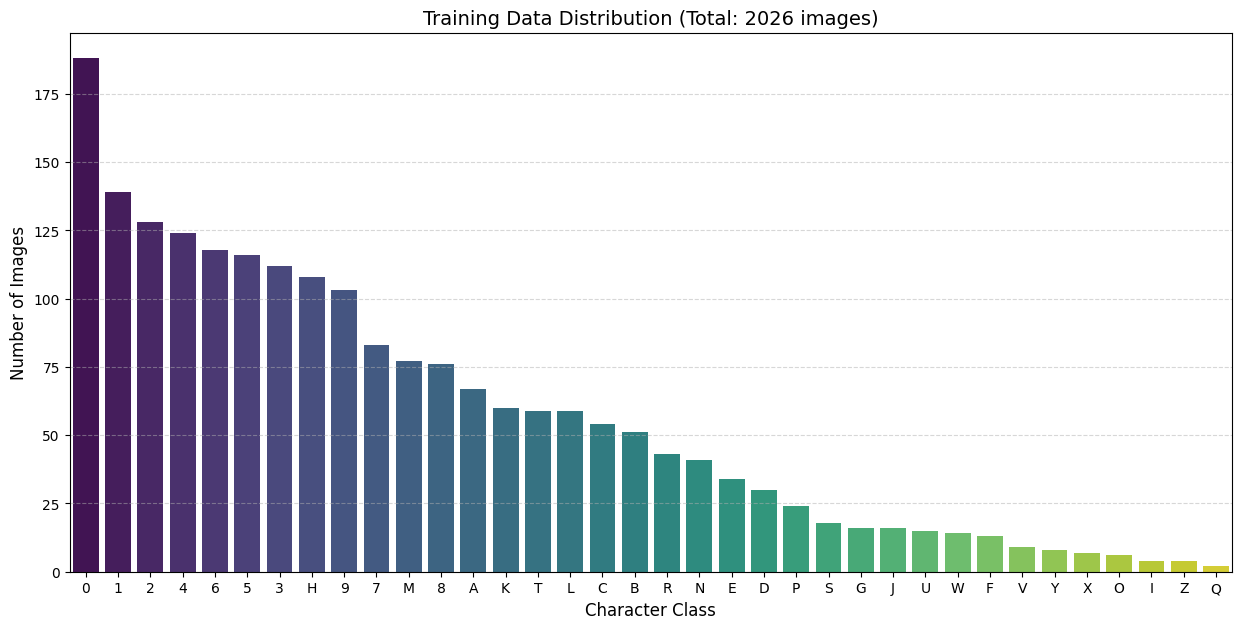

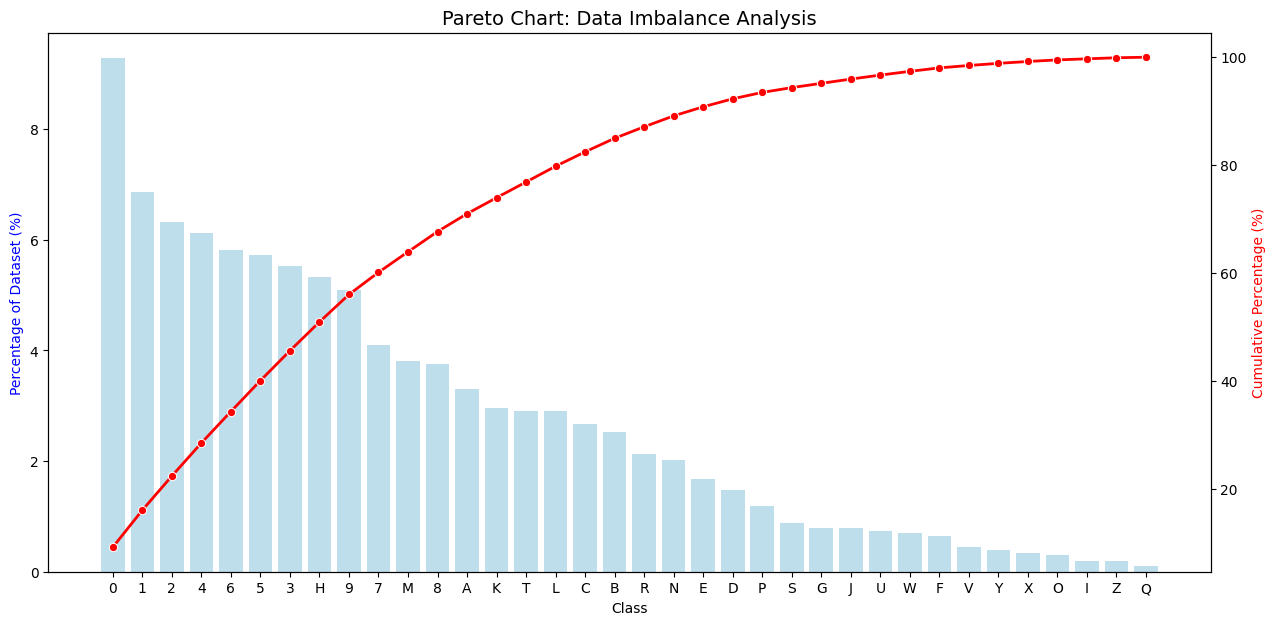


--- Data Statistics ---
Total Images: 2026
Total Classes: 36
Most Frequent: 0 (188)
Least Frequent: Q (2)
Imbalance Ratio: 94.00


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# CONFIGURATION
# ==========================================
# Use centralized paths
TRAIN_DIR = SVM_TRAIN_DIR
SUPPORTED_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp')

def analyze_and_plot_data(data_dir):
    """
    Dynamically counts images in subdirectories and plots distribution.
    """
    if not os.path.exists(data_dir):
        print(f"Error: Directory '{data_dir}' not found.")
        return

    print(f"Scanning directory: {data_dir}...")

    class_counts = []

    # Iterate through all subfolders (which represent classes)
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)

        if os.path.isdir(class_path):
            # Count files with supported extensions
            files = [f for f in os.listdir(class_path)
                     if f.lower().endswith(SUPPORTED_EXTENSIONS)]
            count = len(files)

            if count > 0:
                class_counts.append({'Class': class_name, 'Count': count})

    # Create DataFrame
    df = pd.DataFrame(class_counts)

    if df.empty:
        print("No images found. Check your directory path.")
        return

    # Sort for visualization
    df_sorted = df.sort_values(by='Count', ascending=False)

    # --- PLOT 1: Class Distribution ---
    plt.figure(figsize=(15, 7))
    sns.barplot(data=df_sorted, x='Class', y='Count', palette='viridis')
    plt.title(f'Training Data Distribution (Total: {df["Count"].sum()} images)', fontsize=14)
    plt.xlabel('Character Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    # --- PLOT 2: Pareto / Imbalance Chart ---
    # Calculate percentages
    df_sorted['Percentage'] = (df_sorted['Count'] / df_sorted['Count'].sum()) * 100
    df_sorted['Cumulative Percentage'] = df_sorted['Percentage'].cumsum()

    plt.figure(figsize=(15, 7))
    ax1 = plt.gca()

    # Bar chart for individual percentages
    sns.barplot(data=df_sorted, x='Class', y='Percentage', color='skyblue', ax=ax1, alpha=0.6)

    # Line chart for cumulative percentage
    ax2 = ax1.twinx()
    sns.lineplot(data=df_sorted, x='Class', y='Cumulative Percentage', color='red', marker='o', ax=ax2, linewidth=2)

    ax1.set_ylabel('Percentage of Dataset (%)', color='blue')
    ax2.set_ylabel('Cumulative Percentage (%)', color='red')
    plt.title('Pareto Chart: Data Imbalance Analysis', fontsize=14)
    plt.show()

    # --- PRINT STATS ---
    print("\n--- Data Statistics ---")
    print(f"Total Images: {df['Count'].sum()}")
    print(f"Total Classes: {df['Class'].nunique()}")
    print(f"Most Frequent: {df_sorted.iloc[0]['Class']} ({df_sorted.iloc[0]['Count']})")
    print(f"Least Frequent: {df_sorted.iloc[-1]['Class']} ({df_sorted.iloc[-1]['Count']})")
    print(f"Imbalance Ratio: {df_sorted.iloc[0]['Count'] / df_sorted.iloc[-1]['Count']:.2f}")

# Run the function
analyze_and_plot_data(TRAIN_DIR)

In [ ]:
import gradio as gr
import joblib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# ==========================================
# 1. SETUP & LOGGING
# ==========================================
def log_msg(message, level="INFO"):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] [{level}] {message}")

log_msg("Initializing Extended Diagnostic Dashboard...")

# Load Model from centralized path
MODEL_PATH = SVC_MODEL_PATH
try:
    loaded_model = joblib.load(MODEL_PATH)
    log_msg(f"✔ Model loaded successfully from {MODEL_PATH}", "SUCCESS")
except Exception as e:
    log_msg(f"✘ Error loading model: {e}", "ERROR")
    loaded_model = None

# ==========================================
# 2. VISUALIZATION HELPERS (FIXED)
# ==========================================
def fig_to_numpy(fig):
    """
    Converts a Matplotlib figure to a Numpy image for Gradio.
    """
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Get the RGBA buffer (Red, Green, Blue, Alpha)
    width, height = fig.canvas.get_width_height()
    buf = canvas.buffer_rgba()

    # Convert to Numpy Array
    image = np.frombuffer(buf, dtype=np.uint8)
    image = image.reshape((height, width, 4)) # Reshape to H x W x 4

    # Convert RGBA to RGB (Drop the Alpha channel)
    image = image[:, :, :3]

    plt.close(fig) # Important: Close plot to save memory
    return image

def get_blue_strip_debug_image(image_path):
    """
    Visualizes the Blue Strip Detection logic.
    """
    img = cv2.imread(image_path)
    if img is None: return np.zeros((100,100,3), dtype=np.uint8)

    # 1. Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define blue range (match your notebook settings)
    lower_blue = np.array([100, 100, 50])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # 2. Create Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle("Step 1: Blue Strip Detection Logic", fontsize=14, fontweight='bold')

    # Original
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Input Image")
    axes[0].axis('off')

    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Blue Pixel Mask (HSV)")
    axes[1].axis('off')

    plt.tight_layout()
    return fig_to_numpy(fig)

def get_segmentation_debug_image(image_path):
    """
    Visualizes the Character Segmentation logic.
    """
    try:
        # Call your existing segmentation function
        characters, positions, plate_img = segmentation(image_path)

        if plate_img is None or len(characters) == 0:
            raise ValueError("No characters found")

        # Dynamic plot size based on number of characters
        num_chars = len(characters)
        # Limit columns to avoid crash if too many chars found
        cols = min(num_chars + 1, 12)
        fig, axes = plt.subplots(1, cols, figsize=(12, 3))
        if num_chars + 1 > 12:
            fig.suptitle(f"Step 2: Segmentation (Showing first {cols-1} chars)", fontsize=14, fontweight='bold')
        else:
            fig.suptitle(f"Step 2: Segmentation ({num_chars} chars found)", fontsize=14, fontweight='bold')

        # Handle case where axes is not a list (if only 1 plot)
        if not isinstance(axes, np.ndarray):
            axes = [axes]

        # Plot Cropped Plate
        if len(plate_img.shape) == 2:
            axes[0].imshow(plate_img, cmap='gray')
        else:
            axes[0].imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Localized Plate")
        axes[0].axis('off')

        # Plot Individual Characters
        for i, char_img in enumerate(characters):
            ax_idx = i + 1
            if ax_idx < len(axes):
                axes[ax_idx].imshow(char_img, cmap='gray')
                axes[ax_idx].set_title(f"Char {i+1}")
                axes[ax_idx].axis('off')

        plt.tight_layout()
        return fig_to_numpy(fig)

    except Exception as e:
        # Create an error image if segmentation fails
        fig, ax = plt.subplots(figsize=(6, 2))
        ax.text(0.5, 0.5, f"Segmentation Visualization Failed:\n{str(e)}",
                ha='center', va='center', fontsize=10, color='red')
        ax.axis('off')
        return fig_to_numpy(fig)

# ==========================================
# 3. MAIN DASHBOARD PIPELINE
# ==========================================
def full_diagnostic_pipeline(image):
    # --- A. Validation ---
    if image is None: return None, None, None, "No Image"
    if loaded_model is None: return image, None, None, "Error: Model not loaded"

    # Generate Transaction ID
    trans_id = datetime.now().strftime("%H%M%S")
    log_msg(f"[{trans_id}] New Request Processing...", "INFO")

    # Save Temp Image
    temp_path = f"temp_debug_{trans_id}.jpg"
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(temp_path, image_bgr)

    # --- B. Debug Visualizations (Step 1 & 2) ---
    log_msg(f"[{trans_id}] Generating debug visuals...", "INFO")
    vis_blue = get_blue_strip_debug_image(temp_path)
    vis_seg = get_segmentation_debug_image(temp_path)

    # --- C. Prediction (Step 3) ---
    pred_text = "N/A"
    try:
        log_msg(f"[{trans_id}] Running prediction...", "INFO")
        pred_text = predict_license_plate(temp_path, loaded_model)

        if pred_text:
            status = f"SUCCESS: {pred_text}"
            color = (0, 200, 0)
        else:
            status = "⚠ No Plate Detected"
            color = (0, 0, 255)
            pred_text = "No Detection"

    except Exception as e:
        status = f"ERROR: {str(e)}"
        color = (0, 0, 255)
        log_msg(f"[{trans_id}] Exception: {e}", "ERROR")

    # --- D. Final Overlay ---
    # Create the display image with the result text
    display_img = cv2.copyMakeBorder(image_bgr, 60, 0, 0, 0, cv2.BORDER_CONSTANT, value=(30, 30, 30))
    cv2.putText(display_img, f"Result: {pred_text}", (20, 45),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2, cv2.LINE_AA)
    display_img_rgb = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)

    return display_img_rgb, vis_blue, vis_seg, status

# ==========================================
# 4. LAUNCH GRADIO
# ==========================================
description = """
### Diagnostic ALPR Dashboard
This dashboard demonstrates the **3-Stage Pipeline** of our project:
1.  **Blue Strip Detection:** Locates the TR flag region using HSV color masking.
2.  **Segmentation:** Cropping the plate and slicing individual characters.
3.  **Recognition:** Classifying each slice using the SVM (HOG) model.
### Requirements:
1.  Images must be taken at a 0.5m - 1.0m off the ground.
2.  Angle must be as straight as possible.
3.  Plate should he illuminated.
4.  Image must not be too far away.
"""


interface = gr.Interface(
    fn=full_diagnostic_pipeline,
    inputs=gr.Image(label="Input Vehicle Image", type="numpy"),
    outputs=[
        gr.Image(label="Final Prediction"),
        gr.Image(label="Step 1: Blue Strip Analysis"),
        gr.Image(label="Step 2: Character Segmentation"),
        gr.Textbox(label="System Logs & Status")
    ],
    title="License Plate Recognition - Diagnostic Mode",
    description=description,
    theme="soft"
)

log_msg("Launching Diagnostic Dashboard...")
interface.launch(share=True, debug=True)

[2025-12-30 19:50:46] [INFO] Initializing Extended Diagnostic Dashboard...
[2025-12-30 19:50:47] [SUCCESS] ✔ Model loaded successfully from /content/drive/MyDrive/LicensePlateRecognition/models/svc/svc_new_dataset_trial.pkl
[2025-12-30 19:50:47] [INFO] Launching Diagnostic Dashboard...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0a82537840d9aea7cb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

[2025-12-30 19:51:26] [INFO] [195126] New Request Processing...
[2025-12-30 19:51:26] [INFO] [195126] Generating debug visuals...
[INFO] Checking for Blue Strip in temp_debug_195126.jpg...
[INFO] Blue strip detected. Using strip-based logic.
[2025-12-30 19:51:27] [INFO] [195126] Running prediction...
[INFO] Checking for Blue Strip in temp_debug_195126.jpg...
[INFO] Blue strip detected. Using strip-based logic.
Found 8 characters.
RAW PREDICTION:     34BE8477
SMART CORRECTED:    34BE8477
FINAL PREDICTION:   34BE8477


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

[2025-12-30 19:56:28] [INFO] [195628] New Request Processing...
[2025-12-30 19:56:28] [INFO] [195628] Generating debug visuals...
[INFO] Checking for Blue Strip in temp_debug_195628.jpg...
[INFO] Blue strip detected. Using strip-based logic.
[2025-12-30 19:56:29] [INFO] [195628] Running prediction...
[INFO] Checking for Blue Strip in temp_debug_195628.jpg...
[INFO] Blue strip detected. Using strip-based logic.
Found 8 characters.
RAW PREDICTION:     34BE8477
SMART CORRECTED:    34BE8477
FINAL PREDICTION:   34BE8477
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7864 <> https://0a82537840d9aea7cb.gradio.live
